[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ArtIC-TITECH/b3-proj-2024/blob/main/docs/class_01.ipynb)

# 演習について

## 演習の予定  
第一回：ニューラルネットワークを用いたMNISTデータセットの学習  
第二回：過学習、量子化、枝刈り、オートエンコーダ、取り組むテーマの決定  
第三回：実験、発表資料作成  
第四回：発表練習

## 取り組むテーマの例
### 精度改善
- 最適化関数におけるMomentumの評価
- 適切な学習率とバッチサイズの決定方法

### モデルのパラメータ数削減
- 適切な量子化パラメータの決定方法
- 枝刈りによる性能低下の評価

### その他
- オートエンコーダによるMNISTのデノイジング
- 敵対的サンプルへの耐性評価

# ニューラルネットワークを用いたMNISTデータセットの学習

## 目次

1. ニューラルネットワークを用いた線形関数の近似
2. ニューラルネットワークを用いた手書き文字認識

## 1. ニューラルネットワークを用いた線形関数の近似

ニューラルネットワークは、ChatGPTや画像生成AIなどの基盤となる技術です。  
その基本原理は、関数近似に基づいており、複雑な関数を近似できるのが特徴です。  
この章では、ニューラルネットワークで関数近似を行う簡単な例を紹介します。

ニューラルネットワークの学習は以下の流れで行います。
1. データセットの作成
1. モデルの作成
1. 損失関数、最適化関数の定義
1. モデルの学習
1. モデルの評価

今回の例ではニューラルネットワークのモデルとしてy=wx+bを用意して、そのモデルにy=2x+1を学習させます。  具体的には以下のような流れです。
1. y=2x+1のデータを作成
1. 初期値をw=0, b=0としてモデルy=wx+bを作成
1. 最小化するべき関数とw, bの更新式を定義
1. wとbを更新
1. 得られたw, bを確認

本題に入る前に本日使用するライブラリをimportします。

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

### 1-1.データセットの作成

ニューラルネットワークの学習に用いるデータセットを作成します。今回の例ではy=2x+1の関数近似をします。

In [ ]:
w = 2  # 傾き
b = 1  # 切片
x_train = np.linspace(0, 9, 10)  # 0から9までの10個のデータ点を生成
y_train = w * x_train + b  # 真の線形関数

In [ ]:
x_train

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [ ]:
y_train

array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19.])

データ型をNumpyのarrayからPyTorchのtensorに変換します。PyTorchの処理の都合上、view(-1, 1)を使って形状を(10, 1)にします。

In [ ]:
# Tensorに変換
x_train = torch.tensor(x_train, dtype=torch.float32).view(-1, 1)  # (10, 1) の形に
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # (10, 1) の形に

In [ ]:
x_train

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])

In [ ]:
y_train

tensor([[ 1.],
        [ 3.],
        [ 5.],
        [ 7.],
        [ 9.],
        [11.],
        [13.],
        [15.],
        [17.],
        [19.]])

### 1-2.モデルの作成

ニューラルネットワークを作成します。
``` Python
self.linear=nn.Linear(入力サイズ, 出力サイズ)  
```
は(出力サイズ$\times$入力サイズ)の重み行列$\mathbf{W}$と(出力サイズ)のバイアスベクトル$b$を生成します。  
そして(入力サイズ)のベクトルxを入力した際、self.linear(x)は$\mathbf{W}x+b$を返します。  
今回は入力サイズも出力サイズも1なので$y=wx+b$とかけます。

In [ ]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)  # 入力1、出力1の線形層
        init.constant_(self.linear.weight, 0)  # 重みwをすべて0に初期化
        init.constant_(self.linear.bias, 0)    # バイアスbをすべて0に初期化

    def forward(self, x):
        return self.linear(x)

# モデルのインスタンスを作成
model = LinearRegressionModel()

重みwとバイアスbをどちらも0にしたのでモデルはy=0x+0=0となり、入力に関わらず出力は0になります。

In [ ]:
model(torch.Tensor([1])) # モデルにx=1を入れた際の結果

tensor([0.], grad_fn=<ViewBackward0>)

In [ ]:
model(torch.Tensor([[0], [1], [2], [3]])) # x=0からx=3までを入力した結果をまとめて確認することもできます

tensor([[0.],
        [0.],
        [0.],
        [0.]], grad_fn=<AddmmBackward0>)

モデルが現在y=0x+0であることは以下のプロットで確認できます。

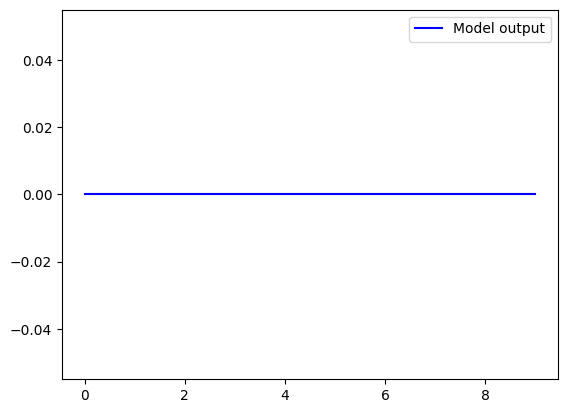

In [ ]:
with torch.no_grad():
    predicted = model(x_train).detach().numpy()

plt.plot(x_train.numpy(), predicted, label='Model output', color='blue')
plt.legend()
plt.show()

###1-3. 損失関数, 最適化関数の定義

詳細は後述しますが  
損失関数としてMSELoss (Mean squared error, 平均二乗誤差)を使用します。  
また最適化関数としてSGD (Stochastic gradient descent, 確率的勾配降下法)を使用します。

In [ ]:
criterion = nn.MSELoss()  # 平均二乗誤差を損失関数として使用
optimizer = optim.SGD(model.parameters(), lr=0.01) # 確率的勾配降下法を最適化関数として使用

### 1-4. モデルの学習


モデルの学習で重要なのが損失関数と最適化関数です。

#### 損失関数について
平均二乗誤差を使ったlossはニューラルネットワークの出力y_pred=wx+bと正解データy_trainを用いて  
$\text{loss}=(\text{y_pred}-\text{y_train})^2=(wx+b-\text{y_train})^2$  
で計算されます。  
例としてx=1のときy=2x+1の正解データはy_train=3です。しかしモデルの出力はy_pred=0だったとします。このときlossは$\text{loss}=(0-3)^2=9$となります。モデルはlossができるだけ小さくなるように学習を行います。

#### 最適化関数について
lossを小さくするために、モデルは$y=wx+b$の$w$と$b$をそれぞれ大きくするべきか、小さくするべきか知りたいです。これを知るためにlossをwやbで微分した結果が役立ちます。  
$$
\frac{\partial\text{loss}}{\partial{w}}=2(wx+b-\text{y_train})x
$$
が0より大きい場合、wを増やすとlossも大きくなります。反対に0より小さい場合、wを減らすとlossが大きくなります。  
したがって$\lambda(>0)$を微小量として以下のようにwを更新します。
$$
w = w-\lambda\frac{\partial\text{loss}}{\partial{w}}
$$
$\lambda$は最適化関数を定義する際にlrで指定します。  
``` Python
optimizer = optim.SGD(model.parameters(), lr=0.01)
```

<img src="https://raw.githubusercontent.com/ArtIC-TITECH/b3-proj-2024/refs/heads/main/resources/class_01/58921711597.png" width="70%">



#### 損失と勾配の確認

実際にy=0x+0にx=1を入れた際の損失と勾配を確認します。
近似したい関数はy=2x+1だとします。

In [ ]:
# x=1とします
x = torch.Tensor([1])

# モデルの予測
y = model(x)
y

tensor([0.], grad_fn=<ViewBackward0>)

損失関数  
$\text{loss}=(\text{y_pred}-\text{y_train})^2=(wx+b-\text{y_train})^2$  
は以下のコードで計算できます。

In [ ]:
# lossの表示
loss = criterion(y, 2*x+1)
loss

tensor(9., grad_fn=<MseLossBackward0>)

lossに対するwの勾配
$$
\frac{\partial\text{loss}}{\partial{w}}
$$
は以下のコードで計算できます。

In [ ]:
# 勾配の計算
loss.backward()

# aの勾配の表示
print(model.linear.weight.grad)

tensor([[-6.]])


#### 学習の実行

上記の損失関数と最適化関数でwとbの更新を5回行います。

In [ ]:
epochs = 5
for epoch in range(epochs):
    # モデルの予測
    y_pred = model(x_train)

    # 損失の計算
    loss = criterion(y_pred, y_train)

    # 勾配の初期化
    optimizer.zero_grad()

    # バックプロパゲーション
    loss.backward()

    # 重みの更新
    optimizer.step()

    # 損失を表示
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 133.0000
Epoch [2/5], Loss: 23.0816
Epoch [3/5], Loss: 4.0907
Epoch [4/5], Loss: 0.8086
Epoch [5/5], Loss: 0.2404


### 1-5. モデルの評価

y=2x+1に近いモデルが得られました。

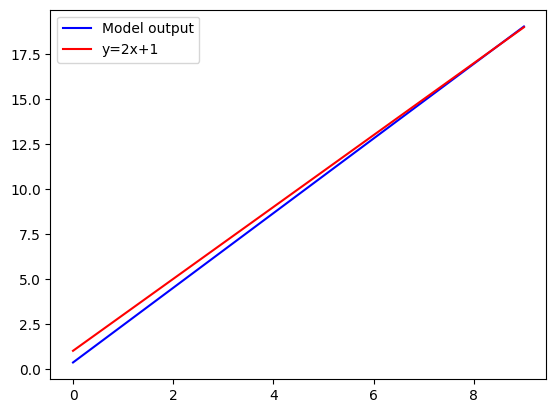

In [ ]:
with torch.no_grad():
    predicted = model(x_train).detach().numpy()

plt.plot(x_train.numpy(), predicted, label='Model output', color='blue')
plt.plot(x_train.numpy(), y_train.numpy(), label='y=2x+1', color='red')
plt.legend()
plt.show()

## 2. ニューラルネットワークを用いた手書き文字認識

### MNISTデータセットについて

MNISTデータセットは0から9までの手書き数字の画像を集めたデータセットです。  
各画像は28x28ピクセルのグレースケール画像です。  
今回は手書き数字の画像を入力した際、その数字を当てるようにニューラルネットワークのモデルの学習を行います。  
手順は線形近似と同様で以下の通りです。

1. データセットの作成
1. モデルの作成
1. 損失関数、最適化関数の定義
1. モデルの学習
1. モデルの評価

### 2-1 データセットの作成

データセットを読み込む前にデータセットに対して行う処理を決めます。


In [ ]:
# 普通のtransform
transform_normal = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# テストデータには普通のtransformを使ってください
transform_for_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ランダム回転を加えたtransform
transform_rotation = transforms.Compose([
    transforms.RandomRotation(60),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ランダム水平反転を加えたtransform
transform_flip = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

データセットの一部を表示する関数です。

In [ ]:
# 画像表示用の関数（3つの画像を横に並べる）
def imshow(img):
    img = img / 2 + 0.5  # Normalizeされた画像の逆変換
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# サンプル画像を取得して表示（3つの画像を並べる）
def show_samples(dataset, title):
    loader = torch.utils.data.DataLoader(dataset, batch_size=3, shuffle=False)  # 3つ取得
    data_iter = iter(loader)
    images, labels = next(data_iter)  # 3つの画像を取得

    print(f"Samples from {title}:")
    imshow(torchvision.utils.make_grid(images, nrow=3))  # 3つ横に並べて表示
    print(labels)

普通のtransformの結果です。(もともとのデータが表示されます。)

Samples from train dataset:


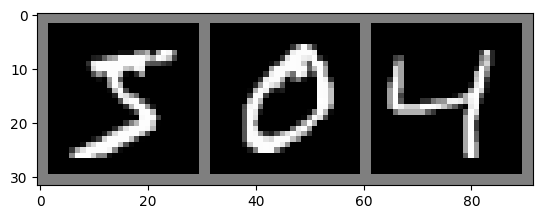

tensor([5, 0, 4])


In [ ]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_normal)
show_samples(train_dataset, "train dataset")

ランダム回転を加えたtransformの結果です。

Samples from train dataset:


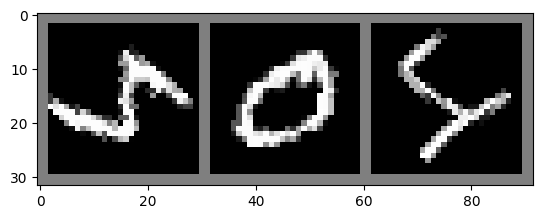

tensor([5, 0, 4])


In [ ]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_rotation)
show_samples(train_dataset, "train dataset")

ランダム水平反転を加えたtransformの結果です。

Samples from train dataset:


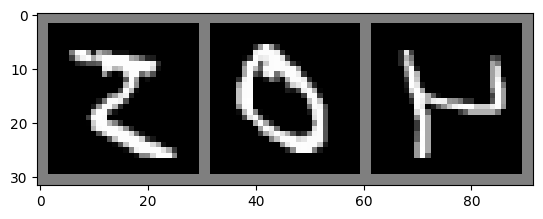

tensor([5, 0, 4])


In [ ]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_flip)
show_samples(train_dataset, "train dataset")

データ変換は複数同時に適用することがほとんどで、そのような場合は`transforms.Compose`を使用して複数のデータ変換を一連の処理として指定します。
```python
transform = transforms.Compose(
    [transforms.ToTensor(),
    ...
     ])
```
のようにpythonのリストで指定し、データを読み込む際に上から順番に実行されます。
適用可能な関数の一覧は[こちら](https://pytorch.org/vision/main/transforms.html)を参照してください。

transformを使うことで、モデルの学習に使うデータの水増しができます。  
今回は普通のtransformを使います。

In [ ]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_normal) # モデルの学習に使うデータセット
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_for_test) # モデルの評価に使うデータセット

In [ ]:
len(train_dataset) # モデルの学習に使うデータセットのサイズ確認

60000

In [ ]:
len(test_dataset) # モデルの評価に使うデータセットのサイズ確認

10000

データセットに含まれるデータ数は非常に大きく、一度にメモリに読み込むことは難しい場合が多いです。  
そのため、そこで一度に読み出すデータの数を減らすことで計算負荷を減らしています。  
これをミニバッチと呼び、ロードするデータ数をバッチサイズと呼びます。

一度にすべてのデータを入力するバッチ処理  
<img src="https://raw.githubusercontent.com/ArtIC-TITECH/b3-proj-2024/refs/heads/main/resources/class_01/batch_gd.png" width="60%">

データを分割して入力するミニバッチ処理  
<img src="https://raw.githubusercontent.com/ArtIC-TITECH/b3-proj-2024/refs/heads/main/resources/class_01/minibatch_gd.webp" width="60%">

pytorchでは、こうしたミニバッチ処理を`DataLoader`というクラスを用いて行います。\
`DataLoader`は`batch_size`という引数で一度に読み出すデータの数を指定することができます。

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

これによってtrain_loaderからデータを1回取り出すごとに64個ずつ、画像とそれに対応するラベルを読み出すことができます。

In [ ]:
for images, labels in train_loader:
    print("Images shape:", images.shape)  # 形状の表示
    print("Labels shape:", labels.shape)  # 形状の表示
    break # 一回目のループで終了

Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


### 2-2.モデルの作成

今回は28$\times$28の手書き数字画像を784(=28$\times$28)個の要素を持つベクトルとして扱います。  
画像は0から9の数字のいずれかなのでモデルは10個の要素を持つベクトルを出力します。ベクトルのそれぞれの要素は0から9の各数字に対応しており、入力された画像に対応するベクトル要素が大きくなりそれ以外の要素が小さくなるように学習を行います。

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self): # モデルのセットアップ
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x): # モデルが行う処理
        x = x.view(-1, 28 * 28)  # 28x28の画像を１次元に変換
        x = self.fc1(x) # ベクトルサイズを28x28から128へ
        x = nn.ReLU()(x) # 活性化関数
        x = self.fc2(x) # ベクトルサイズを128から10へ
        return x

# モデルのインスタンスを作成
model = SimpleModel()

先ほど説明しましたが  
```Python
self.linear=nn.Linear(入力サイズ, 出力サイズ)  
````
は(出力サイズ$\times$入力サイズ)の重み行列 W と(出力サイズ)のバイアスベクトル b を生成します。  
そして(入力サイズ)のベクトル$x$を入力したとき(出力サイズ)のベクトル$y=Wx+b$が得られます。  
- self.fc1 = nn.Linear(28 * 28, 128) は、28$\times$28ピクセルの画像を1次元ベクトルに変換し、それを128次元の隠れ層にマッピングします。  
- self.fc2 = nn.Linear(128, 10) では、128次元の隠れ層から10次元（MNISTの0～9のクラスに対応）にマッピングします。

### 活性化関数
活性化関数とは、入力に対して非線形処理を適用しニューラルネットワークの表現力を向上させるために使用する関数です。

活性化関数には様々な種類がありますが、今回の演習では`ReLU`関数を非線形関数として用います。\
次のコードは入力に対して`ReLU`を適用したもので、$0$以下の入力が全て$0$となることがわかります。\
活性化関数は2つの全結合層(nn.Linear)の間に使用します。

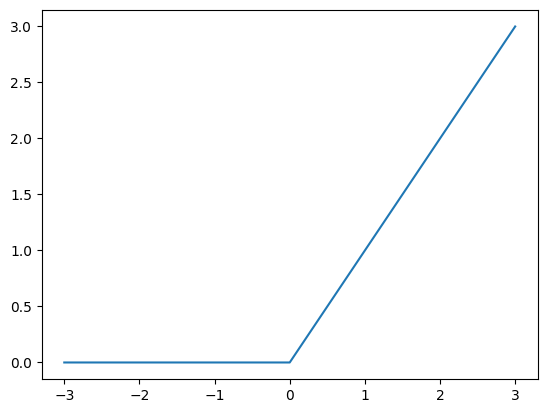

In [ ]:
input = torch.arange(-3, 4)
output = nn.ReLU()(input)
plt.plot(input.numpy(), output.numpy())

### 2-3.損失関数、最適化関数の定義

損失関数としてCrossEntropyLoss (交差エントロピー誤差)を使用します。  
交差エントロピー誤差は[こちら](https://qiita.com/kenta1984/items/59a9ef1788e6934fd962)が参考になります。  
また最適化関数としてSGD (Stochastic gradient descent, 確率的勾配降下法)を使用します。

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

### 2-4.モデルの学習

線形関数の近似と同様に学習を行います。  
先ほどはバッチ学習でしたが今回はミニバッチ学習です。

In [ ]:
epochs = 5
for epoch in range(epochs):
    loss_sum = 0
    for images, labels in train_loader:
        # モデルの予測
        outputs = model(images)

        # 損失の計算
        loss = criterion(outputs, labels)
        loss_sum += loss.item()

        # 勾配の初期化
        optimizer.zero_grad()

        # バックプロパゲーション
        loss.backward()

        # オプティマイザの更新
        optimizer.step()

    # 損失を表示
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss_sum/len(train_loader):.4f}')

Epoch [1/5], Loss: 1.8744
Epoch [2/5], Loss: 1.1697
Epoch [3/5], Loss: 0.8156
Epoch [4/5], Loss: 0.6523
Epoch [5/5], Loss: 0.5644


### 2-5.モデルの評価

モデルの予測結果と正解データは以下のコードで表示できます。

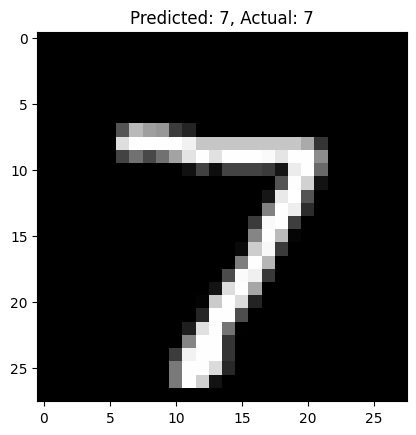

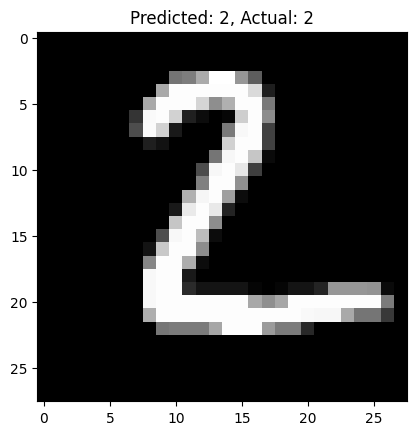

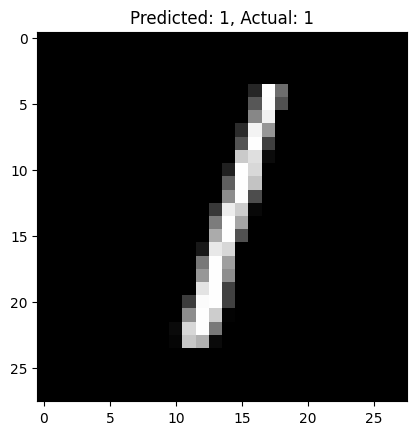

In [ ]:
model.eval() # 評価モード

# 表示する数
num_to_show = 3

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)  # モデルの出力を取得
        _, predicted = torch.max(outputs.data, 1)  # 予測を取得

        # ここで最初の3つの画像を表示
        for i in range(min(len(images), num_to_show)):
            plt.imshow(images[i].squeeze(), cmap='gray')  # 画像を表示
            plt.title(f'Predicted: {predicted[i].item()}, Actual: {labels[i].item()}')
            plt.show()

        break # ループの最初で終了


テストデータを使ってモデルの評価を行います。

In [ ]:
model.eval()  # 評価モード
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 87.12%


## 3. 課題
現在の精度は87.48%です。
以下のコードのうち、変更可能な箇所を自由に変更してモデルの性能を改善してください。

### ライブラリimport
必要に応じて追加してください。

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

### データセット準備
transform_normalの定義は変更可能です。

In [ ]:
# 普通のtransform (変更可能)
transform_normal = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# テストデータには普通のtransformを使ってください
transform_for_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_normal)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_for_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

### モデル定義
すべて変更可能です。

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self): # モデルのセットアップ
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x): # モデルが行う処理
        x = x.view(-1, 28 * 28)  # 28x28の画像を１次元に変換
        x = self.fc1(x) # ベクトルサイズを28x28から128へ
        x = nn.ReLU()(x) # 活性化関数
        x = self.fc2(x) # ベクトルサイズを128から10へ
        return x

# モデルのインスタンスを作成
model = SimpleModel()

### 損失関数、最適化関数の定義
optimizerとlrは変更可能です。

In [ ]:
criterion = nn.CrossEntropyLoss()
# 変更可能
optimizer = optim.SGD(model.parameters(), lr=0.001)

### モデルの学習
epochsは変更可能です。

In [ ]:
epochs = 5
for epoch in range(epochs):
    loss_sum = 0
    for images, labels in train_loader:
        # モデルの予測
        outputs = model(images)

        # 損失の計算
        loss = criterion(outputs, labels)
        loss_sum += loss.item()

        # 勾配の初期化
        optimizer.zero_grad()

        # バックプロパゲーション
        loss.backward()

        # オプティマイザの更新
        optimizer.step()

    # 損失を表示
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss_sum/len(train_loader):.4f}')

Epoch [1/5], Loss: 1.9339
Epoch [2/5], Loss: 1.2147
Epoch [3/5], Loss: 0.8302
Epoch [4/5], Loss: 0.6575
Epoch [5/5], Loss: 0.5668


### モデルの評価
評価は変更しないでください。

In [ ]:
model.eval()  # 評価モード
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 87.48%
